In [1]:
using OffsetArrays, Parameters, Plots, ForwardDiff, NLsolve
using ForwardDiff: jacobian, derivative

In [2]:
gr(fmt = :png);

# Model specification

In [3]:
N = 3 # number of firms per cohort
cohorts = (N, N+1) # cohorts
K = length(cohorts) # number of cohorts
q = range(2.0, 3.0, length = K)
f = fill(1/(N+1)^K, (N+1)^K); # awareness set distribution

In [4]:
params = (cohorts = cohorts, Γ_bar = 1.0, Ω = 1.0, q = q, σ = 5.0, κ = 1.5, mc = 1.0, α = -0.5)

(cohorts = (3, 4), Γ_bar = 1.0, Ω = 1.0, q = 2.0:1.0:3.0, σ = 5.0, κ = 1.5, mc = 1.0, α = -0.5)

# Demand function with 2-type firms

In [5]:
b = 1 # the cohort firm i belongs to
p = fill(1.0, K); # K-vector of prices

### With logit demand
Consider firms belonging to one of the two types $L$ and $H$ with different qualities $q_L$ and $q_H$. There are $N_L$ and $N_H$ number of firms for $L$ and $H$ types respectively. Assume that all the firms are all awared.

Assume demand on $u_j = \alpha p_i + q_i + \epsilon_{ij}$. Firm $i$ on $b$ type faces market share
$$
y_i (p_i, p_{-i}) = \frac{\exp(\alpha p_i + q_b)}{ N_L \exp (\alpha p_L + q_L) + N_H \exp (\alpha p_H + q_H)  - \exp(\alpha p_{b} + q_{b}) +\exp(\alpha p_i + q_{b})  }
$$
Assume constant marginal cost,$c$, so that profits are
$$
\pi_i (p_i, p_{-i}) = (p_i - c) y_i (p_i, p_{-i})
$$

In [6]:
# Demand function with logit demand
# p_i: the price of product of firm i (can be different from p[b])
# b: the cohort firm i belongs to
# p: NK-vector of prices across firms
# f: awareness set distribution
# params: model parameters
function demand(p_i, b, p, f, params)
    @unpack cohorts, Γ_bar, Ω, q, σ, κ, α = params
    exponentials = exp.(α*p.+q)
    exponentials_sum = sum(cohorts .* exponentials) # summation by cohorts
    numerator = exp(α*p_i + q[b])
    return numerator / (exponentials_sum - exponentials[b] + numerator)
end

profit(p_i, b, p, f, params) = (p_i - params.mc) * demand(p_i, b, p, f, params)
profit_derivative(p_i, b, p, f, params) = derivative(p_i -> profit(p_i, b, p, f, params), p_i)

profit_derivative (generic function with 1 method)

## Plots

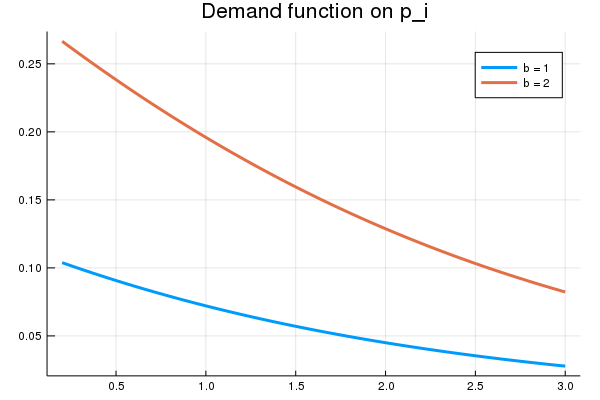

In [7]:
# plot the demand function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> demand(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Demand function on p_i")

In [8]:
# confirm that the demand function is decreasing in price
@assert all(diff((p_i -> demand(p_i, b, p, f, params)).(1:100)) .<= 0)

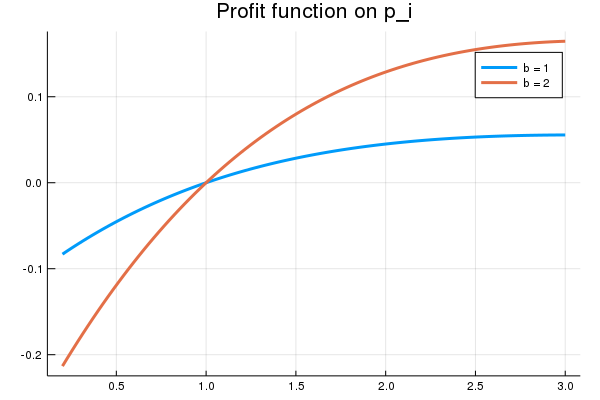

In [9]:
# plot the profit function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i")

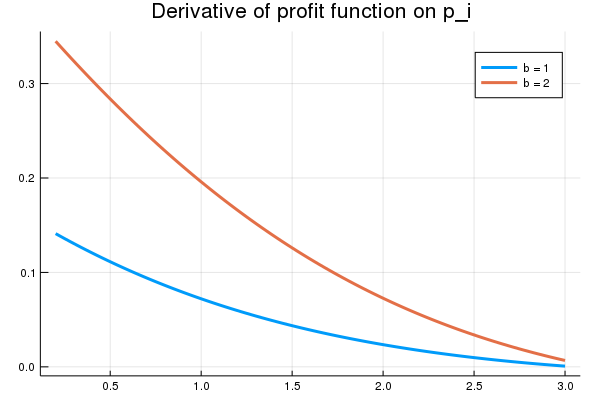

In [10]:
# plot the profit derivative function
plot(range(0.2,stop=3.0,length=100), (b -> (p_i -> profit_derivative(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Derivative of profit function on p_i")

# Nash equilibria

In [11]:
function D_p(p, f, params)
    # K-vector of cohorts where ith element represents ith firms' cohort
    bs = 1:length(params.cohorts)
    # return the vector of derivatives
    return [profit_derivative(p[b], bs[b], p, f, params) for b in eachindex(p)]
end

function nash_equilibrium(f, params; autodiff=:forward, iv = fill(params.mc, length(params.cohorts)))
    sol = nlsolve(p -> D_p(p, f, params), iv, autodiff = autodiff)
    return (p = sol.zero, converged = converged(sol), solution = sol)
end

nash_equilibrium (generic function with 1 method)

In [12]:
p = nash_equilibrium(f, params).p 

2-element Array{Float64,1}:
 3.1755053028149955
 3.4675972854852883

## Plots

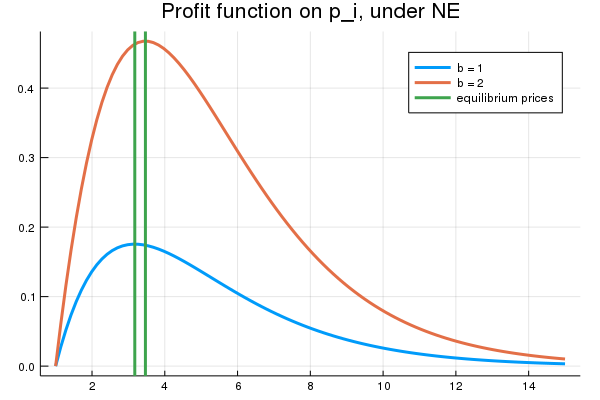

In [13]:
plot(range(1.0,stop=15.0,length=100), (b -> (p_i -> profit(p_i, b, p, f, params))).(1:K),
    label = string.("b = ",1:K), lw = 3, title = "Profit function on p_i, under NE")
plot!(p, st = :vline, lw = 3, label = "equilibrium prices")